# Pt 2 análise de risco de crédito modelos diferentes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve
from matplotlib import pyplot

In [2]:
df = pd.read_csv('credit_risk_dataset.csv', sep = ',')

# Utilizando apenas as variáveis que o modelo selecionou como relevantes através do p-valor

In [3]:
# teste 3 

y = df['loan_status']

encoder = OrdinalEncoder(categories=[['A', "B", "C", "D", 'E', 'F', 'G']])
X = df[['loan_grade', 'loan_amnt', 'loan_percent_income']]
X['loan_grade'] = encoder.fit_transform(X[['loan_grade']])



/tmp/ipykernel_14411/1731617212.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['loan_grade'] = encoder.fit_transform(X[['loan_grade']])


### Dividindo os dados para fazermos cross validation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size=0.2, random_state=42)

### Ajustando o modelo de regressão logística

Estou ajustando usando duas bibliotecas diferentes, porque o modelo do statsmodel mostra uma descrição do modelo mais fácil de ser visualizada.

In [5]:
model = LogisticRegression()
model.fit(X_train, y_train)
model1 = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.574519
         Iterations 6


In [6]:
y_pred = model.predict(X_test)
y_predm1 = model1.predict(X_test)

In [7]:
print(model1.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                26064
Model:                          Logit   Df Residuals:                    26061
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                -0.09523
Time:                        13:18:22   Log-Likelihood:                -14974.
converged:                       True   LL-Null:                       -13672.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_grade              0.1890      0.011     16.729      0.000       0.167       0.211
loan_amnt              -0.0002    3.6e-06    -50.909      0.000      -0.000      -0.000
loan_percent_inc

### Podemos observar o valor dos coeficientes e seus respectivos p-valores, desvio padrão da estimativa dos coeficientes e intervalo de confiança.
### A idade da pessoa tem coeficiente negativo indicando que quando a idade aumenta a chance de inadimplência diminui, o mesmo com a renda da pessoa, o tempo em que a pessoa está empregada, a quantidade no empréstimo, taxa de juros, todas as intenções para o empréstimo e quando a pessoa possui a própria residência. 

In [8]:
print(model1.params < 0 )

loan_grade             False
loan_amnt               True
loan_percent_income    False
dtype: bool


### quais coeficientes possuem p-valor maior que o nível de significância de 5%?

In [9]:
print(model1.pvalues >= 0.05 )

loan_grade             False
loan_amnt              False
loan_percent_income    False
dtype: bool


### Apenas a intenção de melhorar a residência, possuir e própria residência, e se a pessoa já foi inadimplente que possuem p-valor maior que 0.05 o p-valor pode ser menor do que 0.05 por conta da aleatoriedade mesmo ou estas variáveis não agregam tanto assim para a predição mesmo.

In [10]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred, labels=model.classes_)
report = classification_report(y_test, y_pred)

In [11]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred, labels=model.classes_)
report = classification_report(y_test, y_pred)

In [12]:
print("Acurácia:",accuracy)

Acurácia: 0.834279576492251


In [13]:
print('report:', report)

report:               precision    recall  f1-score   support

           0       0.86      0.95      0.90      5095
           1       0.69      0.43      0.53      1422

    accuracy                           0.83      6517
   macro avg       0.78      0.69      0.71      6517
weighted avg       0.82      0.83      0.82      6517



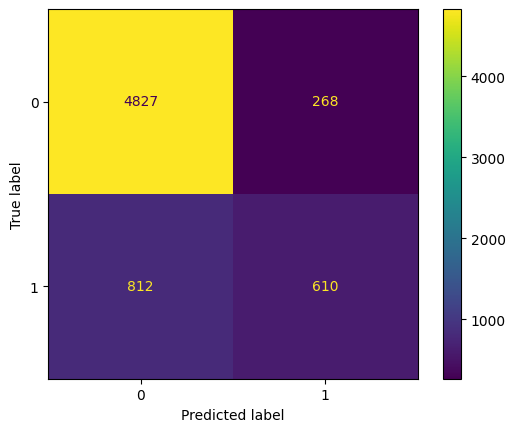

In [14]:

disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=model.classes_)
disp.plot()
plt.show()

In [15]:
print('Precisão é aproximadamente 69,47%' )
print('Sensitividade é aproximadamente 57,10%')
print('Especifidade é aproximadamente 94,73%')

Precisão é aproximadamente 69,47%
Sensitividade é aproximadamente 57,10%
Especifidade é aproximadamente 94,73%


### O nosso modelo está com uma sensitividade baixa e uma especifidade alta, isso quer dizer que ele classifica os não inadimplentes de forma correta na maior parte das vezes que ele classifica como não inadimplente, mas quando ele classifica como inadimplente ele erra a maior parte das vezes, e que ele classifica inadimplentes como não inadimplentes com frequencia.

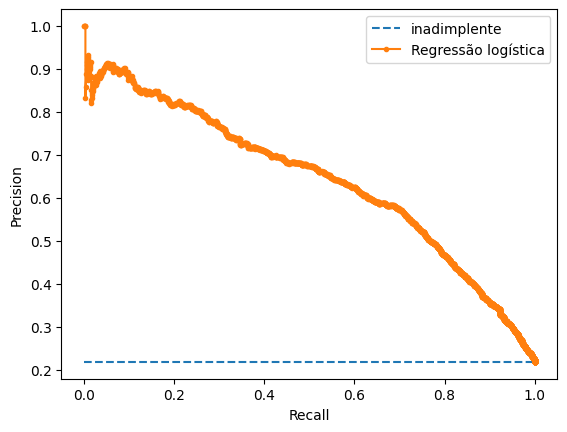

In [16]:
# probabilidade das predições
y_chapeu = model.predict_proba(X_test)
pos_probs = y_chapeu[:, 1] # prob de positivo.
# calculando linha de inadimplentes 
inadimplente = len(y[y==1])/len(y)

# plot da precision-recall curve do grupo de inadimplentes
pyplot.plot([0, 1], [inadimplente, inadimplente], linestyle='--', label='inadimplente')

# calculando precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Regressão logística')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


# Utilizando Dummie variables:

In [17]:
# teste 2
y = df['loan_status']
X = pd.get_dummies(df, columns=['loan_grade', 'loan_intent', 'person_home_ownership', 'cb_person_default_on_file'])
X = X.drop('loan_status', axis = 1)


### Dividindo os dados para fazermos cross validation

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size=0.2, random_state=42)

### Agora vamos substituir os dados faltantes

In [20]:
X_train['loan_int_rate'] = X_train['loan_int_rate'].fillna(np.mean(X_train['loan_int_rate']))
X_train['person_emp_length'] = X_train['person_emp_length'].fillna(np.mean(X_train['person_emp_length']))

X_test['loan_int_rate'] = X_test['loan_int_rate'].fillna(np.mean(X_test['loan_int_rate']))
X_test['person_emp_length'] = X_test['person_emp_length'].fillna(np.mean(X_test['person_emp_length']))


### Ajustando o modelo de regressão logística

Estou ajustando usando duas bibliotecas diferentes, porque o modelo do statsmodel mostra uma descrição do modelo mais fácil de ser visualizada.

In [21]:
model = LogisticRegression()
model.fit(X_train, y_train)
model1 = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.339634
         Iterations 8


In [22]:
y_pred = model.predict(X_test)
y_predm1 = model1.predict(X_test)

In [23]:
print(model1.summary())

                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                26064
Model:                          Logit   Df Residuals:                    26041
Method:                           MLE   Df Model:                           22
Date:                Wed, 27 Sep 2023   Pseudo R-squ.:                  0.3525
Time:                        13:20:24   Log-Likelihood:                -8852.2
converged:                       True   LL-Null:                       -13672.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
person_age                        -0.0051      0.006     -0.813      0.416      -0.017       0.007
person_income                   6.986e-07   3.35e-07      2.087      0.

### Podemos observar o valor dos coeficientes e seus respectivos p-valores, desvio padrão da estimativa dos coeficientes e intervalo de confiança.
### A idade da pessoa tem coeficiente negativo indicando que quando a idade aumenta a chance de inadimplência diminui, o mesmo com a renda da pessoa, o tempo em que a pessoa está empregada, a quantidade no empréstimo, taxa de juros, todas as intenções para o empréstimo e quando a pessoa possui a própria residência. 

In [24]:
print(model1.params < 0 )

person_age                         True
person_income                     False
person_emp_length                  True
loan_amnt                          True
loan_int_rate                     False
loan_percent_income               False
cb_person_cred_hist_length        False
loan_grade_A                       True
loan_grade_B                       True
loan_grade_C                       True
loan_grade_D                      False
loan_grade_E                      False
loan_grade_F                      False
loan_grade_G                      False
loan_intent_DEBTCONSOLIDATION     False
loan_intent_EDUCATION              True
loan_intent_HOMEIMPROVEMENT       False
loan_intent_MEDICAL                True
loan_intent_PERSONAL               True
loan_intent_VENTURE                True
person_home_ownership_MORTGAGE     True
person_home_ownership_OTHER       False
person_home_ownership_OWN          True
person_home_ownership_RENT        False
cb_person_default_on_file_N        True


### quais coeficientes possuem p-valor maior que o nível de significância de 5%?

In [25]:
print(model1.pvalues >= 0.05 )

person_age                         True
person_income                     False
person_emp_length                 False
loan_amnt                         False
loan_int_rate                     False
loan_percent_income               False
cb_person_cred_hist_length         True
loan_grade_A                      False
loan_grade_B                      False
loan_grade_C                      False
loan_grade_D                      False
loan_grade_E                      False
loan_grade_F                      False
loan_grade_G                      False
loan_intent_DEBTCONSOLIDATION     False
loan_intent_EDUCATION             False
loan_intent_HOMEIMPROVEMENT       False
loan_intent_MEDICAL               False
loan_intent_PERSONAL              False
loan_intent_VENTURE               False
person_home_ownership_MORTGAGE    False
person_home_ownership_OTHER       False
person_home_ownership_OWN         False
person_home_ownership_RENT        False
cb_person_default_on_file_N        True


### Apenas a intenção de melhorar a residência, possuir e própria residência, e se a pessoa já foi inadimplente que possuem p-valor maior que 0.05 o p-valor pode ser menor do que 0.05 por conta da aleatoriedade mesmo ou estas variáveis não agregam tanto assim para a predição mesmo.

In [26]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred, labels=model.classes_)
report = classification_report(y_test, y_pred)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred, labels=model.classes_)
report = classification_report(y_test, y_pred)

In [28]:
print("Acurácia:",accuracy)

Acurácia: 0.8029768298296762


In [29]:
print('report:', report)

report:               precision    recall  f1-score   support

           0       0.81      0.98      0.89      5095
           1       0.72      0.16      0.26      1422

    accuracy                           0.80      6517
   macro avg       0.76      0.57      0.57      6517
weighted avg       0.79      0.80      0.75      6517



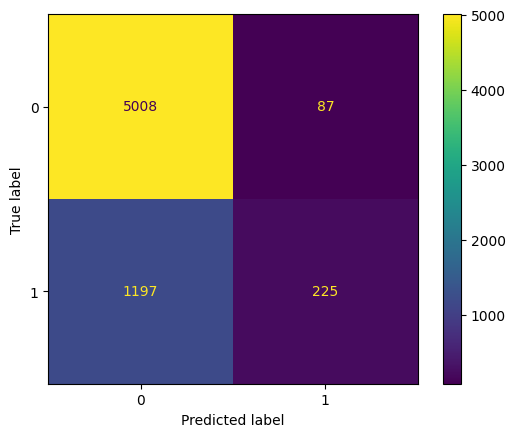

In [30]:

disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=model.classes_)
disp.plot()
plt.show()

In [31]:
print('Precisão é aproximadamente 69,47%' )
print('Sensitividade é aproximadamente 57,10%')
print('Especifidade é aproximadamente 94,73%')

Precisão é aproximadamente 69,47%
Sensitividade é aproximadamente 57,10%
Especifidade é aproximadamente 94,73%


### O nosso modelo está com uma sensitividade baixa e uma especifidade alta, isso quer dizer que ele classifica os não inadimplentes de forma correta na maior parte das vezes que ele classifica como não inadimplente, mas quando ele classifica como inadimplente ele erra a maior parte das vezes, e que ele classifica inadimplentes como não inadimplentes com frequencia.

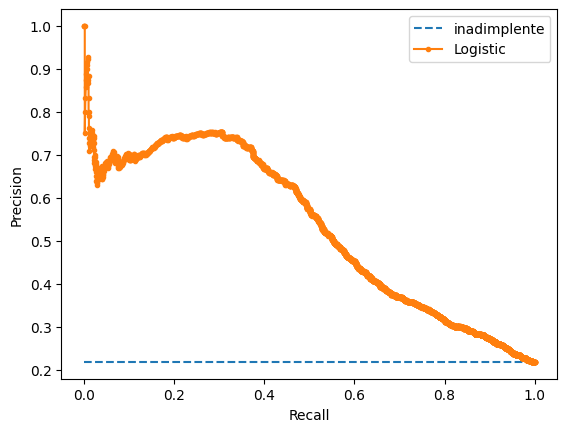

In [32]:
# probabilidade das predições
y_chapeu = model.predict_proba(X_test)
pos_probs = y_chapeu[:, 1] # prob de positivo.
# calculando linha de inadimplentes 
inadimplente = len(y[y==1])/len(y)

# plot da precision-recall curve do grupo de inadimplentes
pyplot.plot([0, 1], [inadimplente, inadimplente], linestyle='--', label='inadimplente')

# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
